# Compare ROMS temperature profile with ARGO data

See `extract_roms_4dvar_argo.ipynb` for details of how the data was extracted

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
from scipy.interpolate import PchipInterpolator

from glob import glob
from matplotlib import rcParams
from soda.dataio.roms.romsio import  get_depth
from soda.utils.inpolygon import inpolygon

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'



Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


Warning - could not import octant package.


In [3]:
argodata = '../DATA/ARGO_gridded_temp.nc'
roms4dfile = '../DATA/ROMS_4DVar_ARGO_temp.nc'
romsfile = '../DATA/ROMS_ARGO_temp.nc'

roms4d = xr.open_dataset(roms4dfile)
roms = xr.open_dataset(romsfile)
argo = xr.open_dataset(argodata)
roms

<xarray.Dataset>
Dimensions:    (JULD: 157, N_PROF: 157, pressure: 70)
Coordinates:
  * pressure   (pressure) float32 4.2 9.0 14.4 19.2 ... 1799.1 1899.2 1986.8
  * JULD       (JULD) datetime64[ns] 2017-04-18T18:00:00 ... 2017-03-20T09:00:00
Dimensions without coordinates: N_PROF
Data variables:
    watertemp  (N_PROF, pressure) float64 ...
    LONGITUDE  (N_PROF) float64 ...
    LATITUDE   (N_PROF) float64 ...

In [4]:
# Check that everything is closely spaced
dt = (roms['JULD'].values - argo['JULD'].values).astype('timedelta64[s]')
dx = roms['LONGITUDE'].values - argo['LONGITUDE'].values
dy = roms['LATITUDE'].values - argo['LATITUDE'].values
Z = -argo['pressure'].values
dt, np.abs(dx+1j*dy),Z

(array([ 4400, -4383, -3192,  -134, -1793,  2589,  2351,    96, -1514,
        -2984, -3662,   651, -1924,  1668, -4985,  3085, -2568,   553,
         2174,  1907, -1914,   416,  4940, -4442,  2337, -1505,  5007,
         4881, -4327, -2806,  3479,  1261, -1110,  2398,  -982, -5173,
         -748, -2501, -2122,  2530, -1441,  2176,  2078,  4660, -2398,
         1950, -1461,   339,  2335, -1631, -3207, -1163, -5064,  4971,
         5315,  5051,  2694,   414, -4755, -4953,  3320,  2498, -5072,
        -1469, -4750, -4856, -1195,  -885,  4770,  2106,  -957, -3250,
        -3553,  5197, -1295,  1359, -4437, -1265, -1942,  1505,  4045,
         1587,  4450,  -869,  5147,  4971, -3197,  2403, -4659, -4192,
         1480,  4180, -3080, -1388, -3163,  3522, -3523,  1730,  4137,
         2226, -1357,  2054, -1500,  4133, -5398, -3523,  -376, -4320,
         4707,  2515,  4615, -1612, -1610,  2210,  3342, -2970,  2030,
         2930, -2146,  1587,  4694,  -138, -2084,   961, -1866, -4404,
      

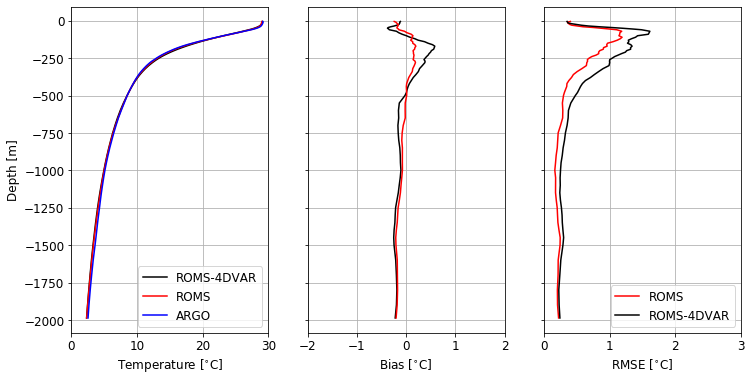

In [8]:
def get_err_stats(myroms,argo):
    err = myroms['watertemp'].values - argo['watertemp'].values

    mu_roms = np.nanmean(myroms['watertemp'].values,axis=0)
    mu_argo = np.nanmean(argo['watertemp'].values,axis=0)

    bias = np.nanmean(err, axis=0)
    rmse = np.sqrt(np.nanmean(err**2, axis=0))
    return mu_roms, mu_argo, bias, rmse

mu_roms, mu_argo, bias, rmse = get_err_stats(roms, argo)
mu_roms_4d, mu_argo_4d, bias_4d, rmse_4d = get_err_stats(roms4d, argo)


plt.figure(figsize=(12,6))
ax3=plt.subplot2grid((1,3),(0,0),colspan=1)
plt.plot(mu_roms_4d, Z,'k')
plt.plot(mu_roms, Z,'r')

plt.plot(mu_argo, Z,'b')
plt.xlabel('Temperature [$^{\circ}$C]')
plt.ylabel('Depth [m]')
plt.grid(b=True)
plt.xlim([0,30])
plt.legend(('ROMS-4DVAR','ROMS','ARGO'), loc='lower right')

# Bias
ax4=plt.subplot2grid((1,3),(0,1),colspan=1)
plt.plot(bias_4d, Z,'k')
plt.plot(bias, Z,'r')
plt.xlim(-2,2)
ax4.set_xticks([-2,-1,0,1,2])
ax4.set_yticklabels([])
plt.xlabel('Bias [$^{\circ}$C]')
plt.grid(b=True)


# RMSE
ax5=plt.subplot2grid((1,3),(0,2),colspan=1)
plt.plot(rmse, Z,'r')
plt.plot(rmse_4d, Z,'k')
plt.xlim(0,3)
ax5.set_yticklabels([])
plt.xlabel('RMSE [$^{\circ}$C]')
plt.grid(b=True)
plt.legend(('ROMS','ROMS-4DVAR'), loc='lower right')
plt.savefig('../FIGURES/ROMS_ARGO_stats.png',dpi=150)
plt.savefig('../FIGURES/ROMS_ARGO_stats.pdf',dpi=150)

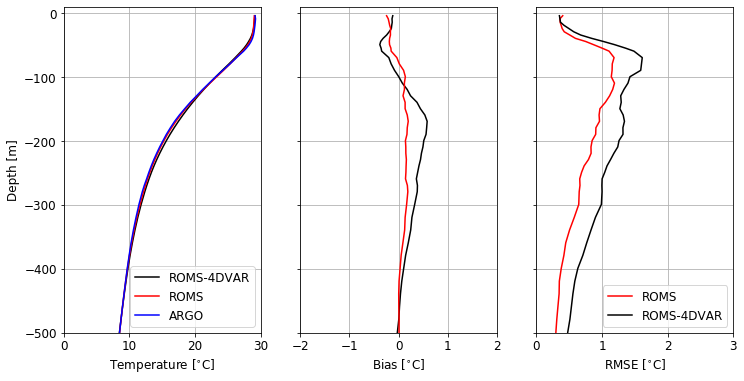

In [9]:
ylim = (-500,10)
plt.figure(figsize=(12,6))
ax3=plt.subplot2grid((1,3),(0,0),colspan=1)
plt.plot(mu_roms_4d, Z,'k')
plt.plot(mu_roms, Z,'r')

plt.plot(mu_argo, Z,'b')
plt.xlabel('Temperature [$^{\circ}$C]')
plt.ylabel('Depth [m]')
plt.grid(b=True)
plt.xlim([0,30])
plt.ylim(ylim)
plt.legend(('ROMS-4DVAR','ROMS','ARGO'), loc='lower right')

# Bias
ax4=plt.subplot2grid((1,3),(0,1),colspan=1)
plt.plot(bias_4d, Z,'k')
plt.plot(bias, Z,'r')
plt.xlim(-2,2)
ax4.set_xticks([-2,-1,0,1,2])
ax4.set_yticklabels([])
plt.xlabel('Bias [$^{\circ}$C]')
plt.grid(b=True)
plt.ylim(ylim)


# RMSE
ax5=plt.subplot2grid((1,3),(0,2),colspan=1)
plt.plot(rmse, Z,'r')
plt.plot(rmse_4d, Z,'k')
plt.xlim(0,3)
plt.ylim(ylim)

ax5.set_yticklabels([])
plt.xlabel('RMSE [$^{\circ}$C]')
plt.grid(b=True)
plt.legend(('ROMS','ROMS-4DVAR'), loc='lower right')
plt.savefig('../FIGURES/ROMS_ARGO_stats.png',dpi=150)
plt.savefig('../FIGURES/ROMS_ARGO_stats.pdf',dpi=150)